<a href="https://colab.research.google.com/github/Rashinisuresh/Carbon-Footprint-/blob/main/Optimized_Public_Transport_Schedule_using_Genetic_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install deap seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.0/136.0 kB 3.0 MB/s eta 0:00:00


In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from deap import base, creator, tools, algorithms


In [3]:
# 24-hour average passenger demand (busy urban route)
avg_passengers_per_hour = [
    200, 180, 150, 120, 100, 150,
    600, 900, 1200, 1000, 900, 800,
    700, 650, 600, 800, 1000, 1400,
    1600, 1000, 700, 500, 400, 300
]

# Safety check
assert len(avg_passengers_per_hour) == 24

# Create dataset table
demand_df = pd.DataFrame({
    "Hour of Day": [f"{h:02d}:00–{h:02d}:59" for h in range(24)],
    "Average Passengers (Traditional System)": avg_passengers_per_hour
})

demand_df


,Hour of Day,Average Passengers (Traditional System)
0,00:00–00:59,200
1,01:00–01:59,180
2,02:00–02:59,150
3,03:00–03:59,120
4,04:00–04:59,100
5,05:00–05:59,150
6,06:00–06:59,600
7,07:00–07:59,900
8,08:00–08:59,1200
9,09:00–09:59,1000


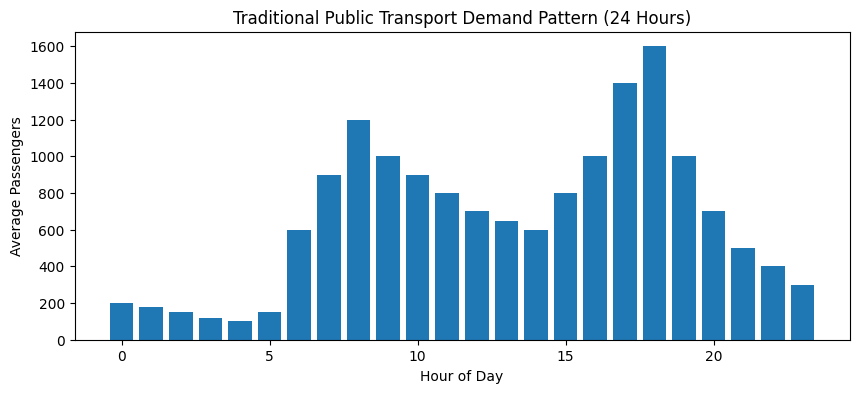

In [4]:
plt.figure(figsize=(10,4))
plt.bar(range(24), avg_passengers_per_hour)
plt.xlabel("Hour of Day")
plt.ylabel("Average Passengers")
plt.title("Traditional Public Transport Demand Pattern (24 Hours)")
plt.show()


In [5]:
passenger_arrivals = []

for hour, hourly_avg in enumerate(avg_passengers_per_hour):
    base = hourly_avg // 60
    remainder = hourly_avg % 60

    for minute in range(60):
        count = base + (1 if minute < remainder else 0)
        passenger_arrivals.extend([hour * 60 + minute] * count)

passenger_arrivals = np.array(passenger_arrivals)


In [6]:
baseline_schedule = np.arange(0, 1440, 15)  # every 15 minutes

baseline_df = pd.DataFrame({
    "Bus Number": range(1, len(baseline_schedule) + 1),
    "Departure Time (Minute of Day)": baseline_schedule
})

baseline_df.head(12)


,Bus Number,Departure Time (Minute of Day)
0,1,0
1,2,15
2,3,30
3,4,45
4,5,60
5,6,75
6,7,90
7,8,105
8,9,120
9,10,135


In [7]:
def average_wait_time(schedule):
    waits = []
    for p in passenger_arrivals:
        future = schedule[schedule >= p]
        if len(future) > 0:
            waits.append(future[0] - p)
    return np.mean(waits)

baseline_avg_wait = average_wait_time(baseline_schedule)

baseline_summary = pd.DataFrame({
    "Metric": [
        "Average Passenger Waiting Time (min)",
        "Number of Buses Operated"
    ],
    "Traditional Schedule Value": [
        round(baseline_avg_wait, 2),
        len(baseline_schedule)
    ]
})

baseline_summary


,Metric,Traditional Schedule Value
0,Average Passenger Waiting Time (min),7.01
1,Number of Buses Operated,96.00


In [8]:
from deap import base, creator, tools, algorithms
import random

# ---- SAFE CREATOR SETUP (prevents redefinition warnings) ----
if "FitnessMulti" not in creator.__dict__:
    creator.create("FitnessMulti", base.Fitness, weights=(-1.0, -1.0))

if "Individual" not in creator.__dict__:
    creator.create("Individual", list, fitness=creator.FitnessMulti)
# ------------------------------------------------------------

NUM_BUSES = 120
MIN_HEADWAY = 5
MAX_HEADWAY = 20

def create_schedule():
    time = 0
    schedule = []
    while time < 1440:
        time += random.randint(MIN_HEADWAY, MAX_HEADWAY)
        schedule.append(time)
    return schedule[:NUM_BUSES]

toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, create_schedule)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


In [9]:
import numpy as np

def evaluate(individual):
    schedule = np.array(individual)
    waits = []

    for passenger_time in passenger_arrivals:
        future_buses = schedule[schedule >= passenger_time]
        if len(future_buses) > 0:
            waits.append(future_buses[0] - passenger_time)

    avg_wait_time = np.mean(waits)
    bus_count = len(schedule)

    return avg_wait_time, bus_count


toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=5, indpb=0.2)
toolbox.register("select", tools.selNSGA2)


In [10]:
population = toolbox.population(n=100)
GENERATIONS = 50

avg_wait_per_generation = []

for gen in range(GENERATIONS):
    population, _ = algorithms.eaMuPlusLambda(
        population,
        toolbox,
        mu=50,
        lambda_=100,
        cxpb=0.7,
        mutpb=0.3,
        ngen=1,
        verbose=False
    )

    avg_wait = np.mean([ind.fitness.values[0] for ind in population])
    avg_wait_per_generation.append(avg_wait)


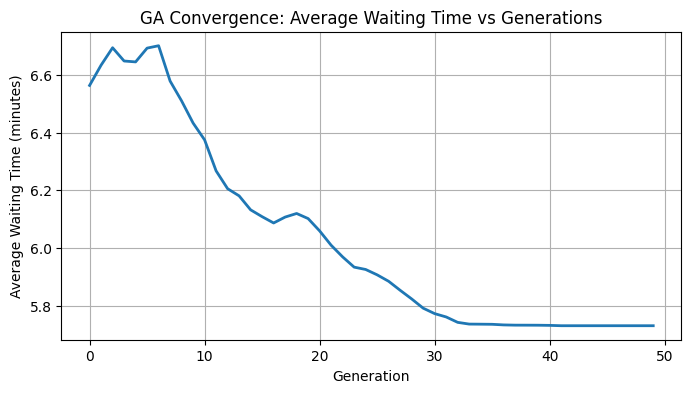

In [11]:
plt.figure(figsize=(8,4))
plt.plot(avg_wait_per_generation, linewidth=2)
plt.xlabel("Generation")
plt.ylabel("Average Waiting Time (minutes)")
plt.title("GA Convergence: Average Waiting Time vs Generations")
plt.grid(True)
plt.show()


In [12]:
pareto_front = tools.sortNondominated(
    population, len(population), first_front_only=True
)[0]


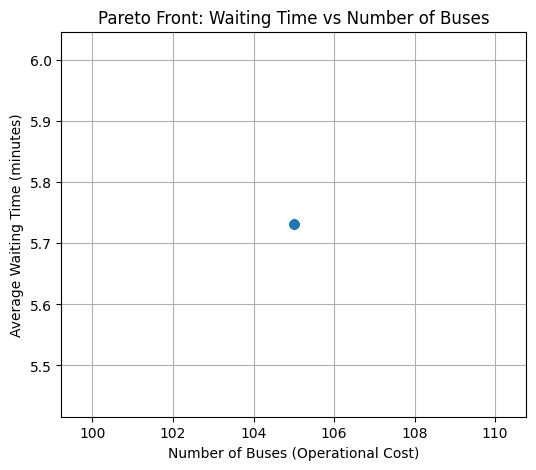

In [13]:
wait_times = [ind.fitness.values[0] for ind in pareto_front]
bus_counts = [ind.fitness.values[1] for ind in pareto_front]

plt.figure(figsize=(6,5))
plt.scatter(bus_counts, wait_times)
plt.xlabel("Number of Buses (Operational Cost)")
plt.ylabel("Average Waiting Time (minutes)")
plt.title("Pareto Front: Waiting Time vs Number of Buses")
plt.grid(True)
plt.show()


In [14]:
best_solution = min(pareto_front, key=lambda ind: ind.fitness.values[0])


In [15]:
optimized_df = pd.DataFrame({
    "Bus Number": range(1, len(best_solution) + 1),
    "Departure Time (Minute of Day)": best_solution
})

optimized_df.head(15)


,Bus Number,Departure Time (Minute of Day)
0,1,11.000000
1,2,26.890296
2,3,44.000000
3,4,61.000000
4,5,76.842442
5,6,86.000000
6,7,98.000000
7,8,103.000000
8,9,122.000000
9,10,134.000000


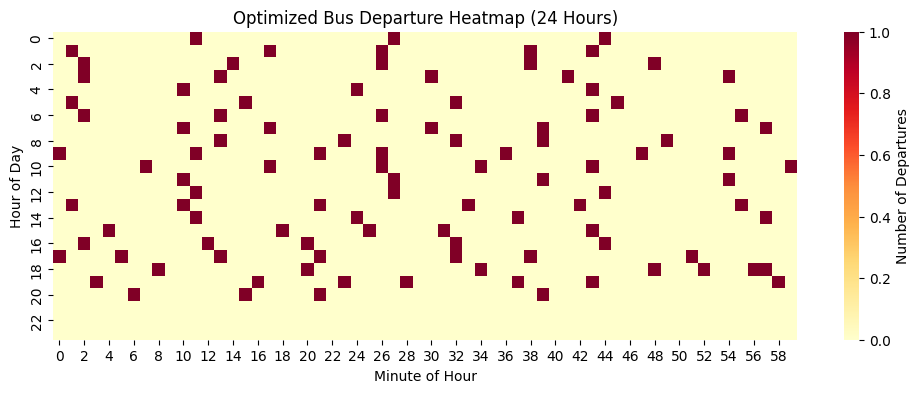

In [19]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

heatmap_data = np.zeros((24, 60))

for t in best_solution:
    t = int(round(t))              # 🔑 FIX: convert to integer
    hour, minute = divmod(t, 60)

    if 0 <= hour < 24 and 0 <= minute < 60:
        heatmap_data[hour, minute] += 1

plt.figure(figsize=(12,4))
sns.heatmap(
    heatmap_data,
    cmap="YlOrRd",
    cbar_kws={"label": "Number of Departures"}
)
plt.xlabel("Minute of Hour")
plt.ylabel("Hour of Day")
plt.title("Optimized Bus Departure Heatmap (24 Hours)")
plt.show()


In [21]:
# Get optimized average waiting time from GA solution
optimized_avg_wait = best_solution.fitness.values[0]

# Percentage improvement calculation
improvement_percent = (
    (baseline_avg_wait - optimized_avg_wait) / baseline_avg_wait
) * 100

# Before vs After comparison table
comparison_table = pd.DataFrame({
    "Metric": [
        "Average Waiting Time (minutes)",
        "Number of Buses Operated",
        "System Type"
    ],
    "Before (Traditional Schedule)": [
        round(baseline_avg_wait, 2),
        len(baseline_schedule),
        "Fixed Interval (15 min)"
    ],
    "After (GA Optimized Schedule)": [
        round(optimized_avg_wait, 2),
        len(best_solution),
        "Demand-Based (GA)"
    ]
})

comparison_table


,Metric,Before (Traditional Schedule),After (GA Optimized Schedule)
0,Average Waiting Time (minutes),7.01,5.73
1,Number of Buses Operated,96,105
2,System Type,Fixed Interval (15 min),Demand-Based (GA)


In [23]:
improvement_table = pd.DataFrame({
    "Metric": ["Waiting Time Reduction (%)"],
    "Value": [round(improvement_percent, 2)]
})

improvement_table


,Metric,Value
0,Waiting Time Reduction (%),18.28


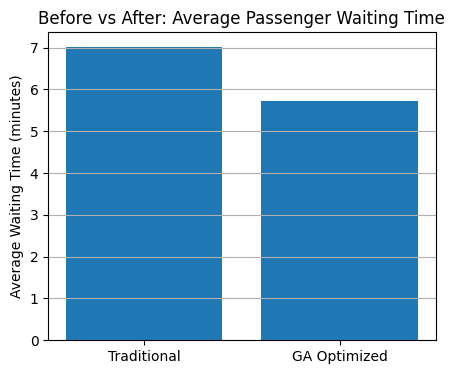

In [25]:
plt.figure(figsize=(5,4))
plt.bar(
    ["Traditional", "GA Optimized"],
    [baseline_avg_wait, optimized_avg_wait]
)
plt.ylabel("Average Waiting Time (minutes)")
plt.title("Before vs After: Average Passenger Waiting Time")
plt.grid(axis="y")
plt.show()
